In [1]:
# Infoscience v library science; m e t a d a t a for libraries
# Beskrivelsen av produksjonslinjen og fremgangsmåten.
# Linked data-modell av det som er gjort; søkbar i SPARQL??? WUT
# 6 Tematikker, 2-3 sider per
# Innhøsting-berikelse-erfaring-formidling
# Formidling av arbeid; HVORFOR og HVORDAN, ikke bare HVA.

# HEIIII vent litt nå. Skal vi ikke heller søke på kommune og deretter hente ut alle postnummere for kommunen for
# å søke i dem? -- Ja, det gjør vi nå.

# PIP rett i Conda-cmd

# Postens data -> SSB, NSD. NSD -> NSD.

# Celle 8:
# Nå har vi problemer. HiO, HiOA og OsloMet er listet enda. Vi må gjøre følgende:
# 1: Få dette her i en liste
# 2: Luke ut duplikater basert på sammenslått navn
# 2 kan oppnås ved å søke med variabel Sammenslått navn i navnefeltet til tabell 123, eller hva?
# !! Noen har sammenslått navn: None
# Kan vi flytte søk til API-siden kanskje?
# if sammenslått navn is not None:
# where sammenslått navn = navn
# ta disse

# ... Flere problemer. 
# USN er ikke synlig om man søker på Drammen, men de har studiested der. Ehhhmmm..
# Hva er "buskerud fylkeskommune" i denne konteksten?

# Arbeidskravet er et refleksjonsnotat på ca. 1 til 1 1/2 sider som dokumenterer produksjonslinjen du jobber med. 
# Du skal redegjøre for hvordan du opplever kvaliteten på datanene og hvordan dataene kan berikes. 
# Arbeidskravet leveres som en markdown fil (.md)

# Frist: 2020-11-06.

In [2]:
import pandas as pd
import json
import requests
import io
from urllib.request import urlopen
# import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# "Brukergrensesnitt"
# Kommunen man er interessert i; husk å gjøre stor forbokstav dersom user input
kommuneNavn = 'ålesund'
# Årstall for statistikk; sjekk om NSD tilbyr statistikk pr år
aarTilSSB = '2020'
# Semester: 1 for vårsemester, 3 for høst. Oppdateres 15. oktober oooog.. en eller annen gang på våren.
semesterTid = "3"

In [4]:
# Variabeldeklarasjon; ikke rør
# INTEGER!! Må gjøres om til string før SSB-søk. I tillegg! str.len og ledende nuller før SSB-søk.
postnummer = 452
kommuneID = 1
prefiksSSB = 'K-'
postnumre = []
dataFunnet = 0
#Default NSD124 for kommuner uten universitet/høgskole
data = [[0]]
nsd124 = pd.DataFrame(data, columns = ['antall'], index=['0'])
#df5a = pd.DataFrame(data, columns = ['antall'], index=['0'])
#df = pd.DataFrame(data, columns = ['antall'], index=['0'])
#df8 = pd.DataFrame(data, columns = ['antall'], index=['0'])

In [5]:
print("Søker i Postens kommune- og postnummerregister...")
df2 = pd.read_csv("resources/postnummerregister.csv", sep=',')
# df2 kommer med stor bokstav foran. Jeg vil helst at det er smått gjennom hele.
df2.columns = ['postnummer','poststed','kommunenummer','kommunenavn','kategori']
# Anvend zfill for å få tilbake ledende nuller i post- og kommunenummer.
df2['postnummer'] = df2['postnummer'].astype(str).str.zfill(4)
df2['kommunenummer'] = df2['kommunenummer'].astype(str).str.zfill(4)

kommuner = []
for kommune in df2['kommunenavn'].unique():
    if kommune not in kommuner:
        kommuner.append(kommune)

if kommuneNavn.upper() in kommuner:
    # Vi søker opp samtlige postnummer i Postens register.
    kommunensPostnummer = df2[df2['kommunenavn'] == kommuneNavn.upper()][['postnummer','kommunenummer']]
    # Vi setter var kommuneID fra samme søk. Kommunenummer skal uansett bare være én verdi hele veien ned.
    kommuneID = kommunensPostnummer['kommunenummer'].values[0]
    # Postnummer settes som et tilfeldig postnummer. Vi bruker ikke denne varaiabelen videre.
    postnummer = kommunensPostnummer['postnummer'].values[0]
    print("OK. Målkommune låst:", kommuneNavn.upper())
else:
    print("Kritisk feil: Er du sikker på at det er en kommune? Har du skrevet navnet _helt_ riktig..?")
    quit()
#print(postnumre)
#kommunensPostnummer

Søker i Postens kommune- og postnummerregister...
OK. Målkommune låst: ÅLESUND


In [6]:
print("Henter alle postnummer fra kommune", kommuneID, kommuneNavn.capitalize() +"...")
if not postnumre:
    print("Oppretter ny liste...")
else:
    print("Tømmer eksisterende liste...")
    postnumre = []
print("Befolker liste...")
# Her henter vi en liste over unike postnummer som skal anvendes for å søke i NSD.
for postnum in kommunensPostnummer['postnummer'].unique():
    if postnum not in postnumre:
        postnumre.append(postnum)
if not postnumre:
    print("Listebefolkning feilet. Kommunen har kanskje ingen postnummer...?")
else:
    print("OK. Hentet", len(postnumre), "unike postnummer fra målkommune.")

Henter alle postnummer fra kommune 1507 Ålesund...
Oppretter ny liste...
Befolker liste...
OK. Hentet 56 unike postnummer fra målkommune.


In [7]:
data = {"tabell_id":124,"api_versjon":1,"statuslinje":"N","begrensning":"10000","kodetekst":"J","desimal_separator":".",
"groupBy":["Institusjonskode", "Årstall", "Kommunenummer campus"],
"sortBy":["Institusjonskode", "Årstall"],
"filter":[
    {
      "variabel": "Studentkategori",
      "selection": {
         "filter": "item",
         "values": [
            "S"
         ],
         "exclude": [
            ""
         ]
      }
   },
   {
      "variabel": "Kommunenummer campus",
      "selection": {
         "filter": "item",
         "values": [
            kommuneID
         ],
         "exclude": [
            ""
         ]
      }
   },
   {
      "variabel": "Årstall",
      "selection": {
         "filter": "item",
         "values": [
            aarTilSSB
         ],
         "exclude": [
            ""
         ]
      }
   },
   {
      "variabel": "Semester",
      "selection": {
         "filter": "item",
         "values": [
            semesterTid
         ],
         "exclude": [
            ""
         ]
      }
   },
    {
      "variabel": "Kjønn",
      "selection": {
         "filter": "all",
         "values": [
            "*"
         ],
         "exclude": [
            ""
         ]
      }
   }
]} 
response = requests.post("https://api.nsd.no/dbhapitjener/Tabeller/hentJSONTabellData", json=data)
if response.status_code == 200:
    if semesterTid == "3":
        print("OK. Responskode 200 - tabell hentet for høstsemesteret", aarTilSSB +".")
        nsddata = json.loads(response.text)
        print("Lagrer data fra NSD...")
        with open('resources/nsd124.json', 'w') as outfile:
            json.dump(nsddata, outfile)
        print("Data lagret.")
        print("Leser data...")
        nsd124 = pd.read_json(r'resources\nsd124.json')
        nsd124.columns = ['institusjonskode','navn','år','kommune','antall']
        print("OK.")
        dataFunnet = 1
    elif semesterTid == "1":
        print("OK. Responskode 200 - tabell hentet for vårsemesteret", aarTilSSB +".")
        nsddata = json.loads(response.text)
        print("Lagrer data fra NSD...")
        with open('resources/nsd124.json', 'w') as outfile:
            json.dump(nsddata, outfile)
        print("Data lagret.")
        print("Leser data...")
        nsd124 = pd.read_json(r'resources\nsd124.json')
        nsd124.columns = ['institusjonskode','navn','år','kommune','antall']
        print("OK.")
        dataFunnet = 1
    else:
        print("... Altså, nå har du klart å søke på et semester som ikke er vår- eller høstsemester. Likevel fikk du respons 200 OK. ???")
        nsddata = json.loads(response.text)
        print("Lagrer data fra NSD...")
        with open('resources/nsd124.json', 'w') as outfile:
            json.dump(nsddata, outfile)
        print("Data lagret.")
        print("Leser data...")
        nsd124 = pd.read_json(r'resources\nsd124.json')
        nsd124.columns = ['institusjonskode','navn','år','kommune','antall']
        print("OK.")
        dataFunnet = 1
elif response.status_code == 201:
    print("Responskode 201 - Created. Ehm... ja. Hva gjorde du nå?\n")
    nsddata = json.loads(response.text)
    print("Lagrer data fra NSD...")
    with open('resources/nsd124.json', 'w') as outfile:
        json.dump(nsddata, outfile)
    print("Data lagret.")
    print("Leser data...")
    nsd124 = pd.read_json(r'resources\nsd124.json')
    nsd124.columns = ['institusjonskode','navn','år','kommune','antall']
    print("OK.")
    dataFunnet = 1
elif response.status_code == 204:
    print("Ingen resultater for denne kommunen.\n")
    nsddata = []
else:
    print("Responskode" +str(response.status_code) +". Noe er feil, eller så kan det hende serveren er nede.\n")
    nsddata = []
# Assign responsen til en variabel, deretter anvend io for å konvertere til pandas dataframe.

OK. Responskode 200 - tabell hentet for høstsemesteret 2020.
Lagrer data fra NSD...
Data lagret.
Leser data...
OK.


In [8]:
#z = 0
#print("Viser campus..\n")
#for i in nsddata:
#    z = z + 1
#    print("Innførsel", z)
#    print("Navn:", i['Institusjonsnavn'])
#    print("Kommunenummer:", i["Kommunenummer campus"])
#    print("Antall:", i["Antall"])
#    print('\n')
#if z != 0:
#        print("Totalt", z, "campus.")
#else:
#    print("Ingen campusinformasjon å vise for", kommuneNavn.capitalize() +".")
if dataFunnet == 1:
    nsd124.drop("institusjonskode", axis=1, inplace=True)
    nsd124.drop("år", axis=1, inplace=True)
    nsd124.drop("kommune", axis=1, inplace=True)

In [9]:
print("Henter kommunedata fra SSB...")
# SSB
# SSBs CSV er ikke UTF-8 (sier dokumentasjonen), så vi angir parameter encoding ISO-8859-1..?
# Gjør kommuneID til str, ikke int.
kommuneTilSSB = prefiksSSB + str(kommuneID)
data = {
  "query": [
    {
      "code": "Region",
      "selection": {
        "filter": "agg:KommSummer",
        "values": [
          kommuneTilSSB,
        ]
      }
    },
    {
      "code": "Kjonn",
      "selection": {
        "filter": "item",
        "values": [
          "1",
          "2"
        ]
      }
    },
    {
      "code": "Alder",
      "selection": {
        "filter": "agg:TiAarigGruppering",
        "values": [
          "F00-09",
          "F10-19",
          "F20-29",
          "F30-39",
          "F40-49",
          "F50-59",
          "F60-69",
          "F70-79",
          "F80-89",
          "F90-99",
          "F100G10+"
        ]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "item",
        "values": [
          aarTilSSB
        ]
      }
    }
  ],
  "response": {
    "format": "csv2"
  }
}
response = requests.post("https://data.ssb.no/api/v0/no/table/07459/", json=data)
if response.status_code == 200:
    print("OK. Responskode 200 - tabell hentet.")
elif response.status_code == 201:
    print("Responskode 201 - Created? .. Ja, det kan jo hende.")
else:
    print("Responskode", response.status_code +". Noe er feil, ellers er serveren nede.")
    quit()
    
# Assign responsen til en variabel, deretter anvend io for å konvertere til pandas dataframe.

ssbdata = response.text
df = pd.read_csv(io.StringIO(ssbdata))
print("Renser data...")
# Her var det mye tjafs. Bokstaver og koder og greier.
# Jeg vil gjerne at df får litt mer lesevennlige kolonnenavn.
df.columns = ['region','kjønn','alder','år','type','populasjon']
df.drop("år", axis=1, inplace=True)
df.drop("type", axis=1, inplace=True)
df.drop("region", axis=1, inplace=True)
# Fjern de første 2 tegn fra Kjønn, og de første 5 tegn fra Alder. Derfor:
# Utryddelse av uønskede karakterer fra SSBs data via Regex
# df['region'] = df['region'].str[7:]
# df['region'].replace('\d\d\d\d ','', inplace=True, regex=True)
# df['region'].replace(r'\(.*\)','', inplace=True, regex=True)
df['kjønn'].replace('\d ','', inplace=True, regex=True)
df['kjønn'].replace('Menn','M', inplace=True, regex=True)
df['kjønn'].replace('Kvinner','F', inplace=True, regex=True)
df['alder'].replace(r"[a-zA-Z]",'', inplace=True, regex=True)
df['alder'].replace(u"\xe5",'', inplace=True, regex=True)
#df.drop("kjønn", axis=1, inplace=True)
#df.drop("alder", axis=1, inplace=True)
# df["personer"] = df["kjønn"] + " " + df["alder"]
#df
print("Data renset.")

Henter kommunedata fra SSB...
OK. Responskode 200 - tabell hentet.
Renser data...
Data renset.


In [10]:
kommuneID

'1507'

In [11]:
print("Henter grunnskoledata fra SSB...")
# SSB
# SSBs CSV er ikke UTF-8 (sier dokumentasjonen), så vi angir parameter encoding ISO-8859-1..?
# Gjør kommuneID til str, ikke int.
data = {
  "query": [
    {
      "code": "KOKkommuneregion0000",
      "selection": {
        "filter": "agg_single:KOGkommuneregion000002004",
        "values": [
          "0101",
          "0104",
          "0105",
          "0106",
          "0111",
          "0118",
          "0119",
          "0121",
          "0122",
          "0123",
          "0124",
          "0125",
          "0127",
          "0128",
          "0135",
          "0136",
          "0137",
          "0138",
          "0211",
          "0213",
          "0214",
          "0215",
          "0216",
          "0217",
          "0219",
          "0220",
          "0221",
          "0226",
          "0227",
          "0228",
          "0229",
          "0230",
          "0231",
          "0233",
          "0234",
          "0235",
          "0236",
          "0237",
          "0238",
          "0239",
          "0301",
          "0402",
          "0403",
          "0412",
          "0415",
          "0417",
          "0418",
          "0419",
          "0420",
          "0423",
          "0425",
          "0426",
          "0427",
          "0428",
          "0429",
          "0430",
          "0432",
          "0434",
          "0436",
          "0437",
          "0438",
          "0439",
          "0441",
          "0501",
          "0502",
          "0511",
          "0512",
          "0513",
          "0514",
          "0515",
          "0516",
          "0517",
          "0519",
          "0520",
          "0521",
          "0522",
          "0528",
          "0529",
          "0532",
          "0533",
          "0534",
          "0536",
          "0538",
          "0540",
          "0541",
          "0542",
          "0543",
          "0544",
          "0545",
          "0602",
          "0604",
          "0605",
          "0612",
          "0615",
          "0616",
          "0617",
          "0618",
          "0619",
          "0620",
          "0621",
          "0622",
          "0623",
          "0624",
          "0625",
          "0626",
          "0627",
          "0628",
          "0631",
          "0632",
          "0633",
          "0701",
          "0702",
          "0704",
          "0706",
          "0709",
          "0710",
          "0711",
          "0712",
          "0713",
          "0714",
          "0715",
          "0716",
          "0719",
          "0720",
          "0722",
          "0723",
          "0728",
          "0729",
          "0805",
          "0806",
          "0807",
          "0811",
          "0814",
          "0815",
          "0817",
          "0819",
          "0821",
          "0822",
          "0826",
          "0827",
          "0828",
          "0829",
          "0830",
          "0831",
          "0833",
          "0834",
          "0901",
          "0904",
          "0906",
          "0911",
          "0912",
          "0914",
          "0919",
          "0926",
          "0928",
          "0929",
          "0935",
          "0937",
          "0938",
          "0940",
          "0941",
          "1001",
          "1002",
          "1003",
          "1004",
          "1014",
          "1017",
          "1018",
          "1021",
          "1026",
          "1027",
          "1029",
          "1032",
          "1034",
          "1037",
          "1046",
          "1101",
          "1102",
          "1103",
          "1106",
          "1111",
          "1112",
          "1114",
          "1119",
          "1120",
          "1121",
          "1122",
          "1124",
          "1127",
          "1129",
          "1130",
          "1133",
          "1134",
          "1135",
          "1141",
          "1142",
          "1144",
          "1145",
          "1146",
          "1149",
          "1151",
          "1160",
          "1201",
          "1211",
          "1216",
          "1219",
          "1221",
          "1222",
          "1223",
          "1224",
          "1227",
          "1228",
          "1231",
          "1232",
          "1233",
          "1234",
          "1235",
          "1238",
          "1241",
          "1242",
          "1243",
          "1244",
          "1245",
          "1246",
          "1247",
          "1251",
          "1252",
          "1253",
          "1256",
          "1259",
          "1260",
          "1263",
          "1264",
          "1265",
          "1266",
          "1401",
          "1411",
          "1412",
          "1413",
          "1416",
          "1417",
          "1418",
          "1419",
          "1420",
          "1421",
          "1422",
          "1424",
          "1426",
          "1428",
          "1429",
          "1430",
          "1431",
          "1432",
          "1433",
          "1438",
          "1439",
          "1441",
          "1443",
          "1444",
          "1445",
          "1449",
          "1502",
          "1504",
          "1505",
          "1511",
          "1514",
          "1515",
          "1516",
          "1517",
          "1519",
          "1520",
          "1523",
          "1524",
          "1525",
          "1526",
          "1528",
          "1529",
          "1531",
          "1532",
          "1534",
          "1535",
          "1539",
          "1543",
          "1545",
          "1546",
          "1547",
          "1548",
          "1551",
          "1554",
          "1557",
          "1560",
          "1563",
          "1566",
          "1567",
          "1571",
          "1573",
          "1576",
          "5001",
          "5004",
          "5005",
          "5011",
          "5012",
          "5013",
          "5014",
          "5015",
          "5016",
          "5017",
          "5018",
          "5019",
          "5020",
          "5021",
          "5022",
          "5023",
          "5024",
          "5025",
          "5026",
          "5027",
          "5028",
          "5029",
          "5030",
          "5031",
          "5032",
          "5033",
          "5034",
          "5035",
          "5036",
          "5037",
          "5038",
          "5039",
          "5040",
          "5041",
          "5042",
          "5043",
          "5044",
          "5045",
          "5046",
          "5047",
          "5048",
          "5049",
          "5050",
          "5051",
          "5052",
          "5053",
          "5054",
          "5061",
          "1601",
          "1612",
          "1613",
          "1617",
          "1620",
          "1621",
          "1622",
          "1624",
          "1627",
          "1630",
          "1632",
          "1633",
          "1634",
          "1635",
          "1636",
          "1638",
          "1640",
          "1644",
          "1648",
          "1653",
          "1657",
          "1662",
          "1663",
          "1664",
          "1665",
          "1702",
          "1703",
          "1711",
          "1714",
          "1717",
          "1718",
          "1719",
          "1721",
          "1724",
          "1725",
          "1736",
          "1738",
          "1739",
          "1740",
          "1742",
          "1743",
          "1744",
          "1748",
          "1749",
          "1750",
          "1751",
          "1755",
          "1756",
          "1804",
          "1805",
          "1811",
          "1812",
          "1813",
          "1815",
          "1816",
          "1818",
          "1820",
          "1822",
          "1824",
          "1825",
          "1826",
          "1827",
          "1828",
          "1832",
          "1833",
          "1834",
          "1835",
          "1836",
          "1837",
          "1838",
          "1839",
          "1840",
          "1841",
          "1845",
          "1848",
          "1849",
          "1850",
          "1851",
          "1852",
          "1853",
          "1854",
          "1856",
          "1857",
          "1859",
          "1860",
          "1865",
          "1866",
          "1867",
          "1868",
          "1870",
          "1871",
          "1874",
          "1902",
          "1903",
          "1911",
          "1913",
          "1917",
          "1919",
          "1920",
          "1922",
          "1923",
          "1924",
          "1925",
          "1926",
          "1927",
          "1928",
          "1929",
          "1931",
          "1933",
          "1936",
          "1938",
          "1939",
          "1940",
          "1941",
          "1942",
          "1943",
          "2002",
          "2003",
          "2004",
          "2011",
          "2012",
          "2014",
          "2015",
          "2017",
          "2018",
          "2019",
          "2020",
          "2021",
          "2022",
          "2023",
          "2024",
          "2025",
          "2027",
          "2028",
          "2030",
          "2111"
        ]
      }
    },
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "KOSelevgrsk0000"
        ]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "top",
        "values": [
          "1"
        ]
      }
    }
  ],
  "response": {
    "format": "csv2"
  }
}
response = requests.post("https://data.ssb.no/api/v0/no/table/11971/", json=data)
if response.status_code == 200:
    print("OK. Responskode 200 - tabell hentet.")
elif response.status_code == 201:
    print("Responskode 201 - Created? .. Ja, det kan jo hende.")
else:
    print("Responskode " +str(response.status_code) +". Noe er feil, ellers er serveren nede.")
# Assign responsen til en variabel, deretter anvend io for å konvertere til pandas dataframe.

ssbdata1 = response.text
df5 = pd.read_csv(io.StringIO(ssbdata1))
print("Renser data...")
df5.columns = ['Navn','1','2','Grunnskoletall']
df5.drop("1", axis=1, inplace=True)
df5.drop("2", axis=1, inplace=True)
df5['Navn'] = df5['Navn'].str[5:]
df5a = df5[df5['Navn'] == kommuneNavn.capitalize()][['Grunnskoletall']]
print("Konverterer data...")
df5a['Grunnskoletall'] = df5a['Grunnskoletall'].astype(int)
print("Data renset.")

Henter grunnskoledata fra SSB...
OK. Responskode 200 - tabell hentet.
Renser data...
Konverterer data...
Data renset.


In [12]:
print("Henter videregående skoler fra SSB...")
data = {
  "query": [
    {
      "code": "KOKbnr0000",
      "selection": {
        "filter": "vs:KOKbnr0000002",
        "values": [
          "00292370",
          "00326224",
          "00326291",
          "00326607",
          "00328782",
          "00329150",
          "00358630",
          "00358983",
          "00408352",
          "00450901",
          "00476846",
          "00517771",
          "00556882",
          "00556890",
          "00557161",
          "00666734",
          "00687928",
          "01280430",
          "01676644",
          "01892185",
          "01892193",
          "01893157",
          "01935968",
          "01936077",
          "01936220",
          "01936247",
          "01936255",
          "01936263",
          "01936271",
          "01936336",
          "01936360",
          "01936379",
          "01936409",
          "01936417",
          "01936425",
          "01936441",
          "01936468",
          "01936476",
          "01936492",
          "01936514",
          "01936530",
          "01936557",
          "01936646",
          "01943413",
          "01943510",
          "01943782",
          "01943839",
          "01943944",
          "01943952",
          "01944002",
          "01944142",
          "01944207",
          "01944215",
          "01944320",
          "01944339",
          "01944444",
          "01944509",
          "01944533",
          "01944703",
          "01944827",
          "01944851",
          "01945114",
          "01954199",
          "01954202",
          "01954229",
          "01954245",
          "01954253",
          "01954288",
          "01954296",
          "01954326",
          "01954334",
          "01954350",
          "01954369",
          "01954377",
          "01954393",
          "01954415",
          "01954458",
          "01954466",
          "01954474",
          "01954482",
          "01954490",
          "01954504",
          "01954520",
          "01954539",
          "01954547",
          "01954563",
          "01954571",
          "01954598",
          "01954601",
          "01954644",
          "01954660",
          "01954687",
          "01954709",
          "01954717",
          "01954725",
          "01954741",
          "01954776",
          "01954806",
          "01954814",
          "01954857",
          "01954865",
          "01954911",
          "01954938",
          "01954946",
          "01954954",
          "01954962",
          "01954970",
          "01954997",
          "01955004",
          "01955012",
          "01955039",
          "01955047",
          "01955063",
          "01955071",
          "01955101",
          "01955136",
          "01955144",
          "01955160",
          "01955195",
          "01955209",
          "01955225",
          "01955276",
          "01955284",
          "01955683",
          "01955705",
          "01956086",
          "01956159",
          "01956167",
          "01956183",
          "01956191",
          "01956205",
          "01956329",
          "01956744",
          "01956841",
          "01956868",
          "01956930",
          "01956949",
          "01956957",
          "01957015",
          "01957023",
          "01957112",
          "01957260",
          "01957317",
          "01957341",
          "01957392",
          "01957414",
          "01957538",
          "01957589",
          "01957635",
          "01957740",
          "01957988",
          "01958046",
          "01958089",
          "01958135",
          "01958143",
          "01958178",
          "01958550",
          "01958585",
          "01958593",
          "01958607",
          "01958615",
          "01958674",
          "01958690",
          "01958712",
          "01958747",
          "01958755",
          "01958771",
          "01958801",
          "01958879",
          "01958925",
          "01958992",
          "01959018",
          "01959085",
          "01959093",
          "01959131",
          "01959166",
          "01962698",
          "01962736",
          "01962779",
          "01962787",
          "01962817",
          "01962833",
          "01962884",
          "01962949",
          "01963007",
          "01963023",
          "01963031",
          "01963058",
          "01963066",
          "01963082",
          "01963090",
          "01963139",
          "01963171",
          "01963228",
          "01963252",
          "01966162",
          "01966170",
          "01982400",
          "01982486",
          "01982540",
          "01982567",
          "01982575",
          "01982613",
          "01982753",
          "01982761",
          "01982826",
          "01982842",
          "01982907",
          "01982915",
          "01982931",
          "01982966",
          "01983008",
          "01983032",
          "01983059",
          "01983067",
          "01983091",
          "01983156",
          "01983261",
          "01983342",
          "01983350",
          "01983369",
          "01983393",
          "01983415",
          "01983512",
          "01983539",
          "01983547",
          "01983555",
          "01983563",
          "01983598",
          "01983644",
          "01983717",
          "01983725",
          "01983741",
          "01983768",
          "01983849",
          "01983881",
          "01983903",
          "01983911",
          "01983946",
          "01983954",
          "01984020",
          "01984047",
          "01984055",
          "01984063",
          "01984101",
          "01984128",
          "01984144",
          "01984179",
          "01984209",
          "01984217",
          "01984683",
          "01996258",
          "01996762",
          "01997041",
          "01997106",
          "02013843",
          "02063050",
          "02064987",
          "02065576",
          "02066440",
          "02202395",
          "02202468",
          "02202883",
          "02203014",
          "02204339",
          "02206218",
          "02359197",
          "02377551",
          "02647222",
          "02647249",
          "02647257",
          "02647303",
          "02647338",
          "03033120",
          "03033147",
          "03034984",
          "03034992",
          "03035727",
          "03035980",
          "03163059",
          "03163490",
          "03174603",
          "03430766",
          "03430774",
          "03432335",
          "03432416",
          "03470334",
          "03470482",
          "03492141",
          "03492168",
          "03492176",
          "03492184",
          "03509346",
          "03509400",
          "03509419",
          "03509435",
          "03519392",
          "03520609",
          "03536637",
          "03542750",
          "03547825",
          "04027329",
          "04043774",
          "04043812",
          "04044517",
          "04048334",
          "04067630",
          "04145275",
          "04166949",
          "04174976",
          "04175859",
          "04180380",
          "04190130",
          "04190149",
          "04190157",
          "04297733",
          "04357353",
          "04358694",
          "04361083",
          "04377761",
          "04395298",
          "04497236",
          "04497260",
          "04497813",
          "04498534",
          "04498550",
          "04505751",
          "04523822",
          "04675525",
          "04701577",
          "04702255",
          "04707990",
          "04711564",
          "04712455",
          "04903145",
          "05037581",
          "05037603",
          "05134390",
          "05167795",
          "05312884",
          "05433983",
          "05490316",
          "05529344",
          "05571723",
          "05670039",
          "05875315",
          "05886104",
          "06338798",
          "06363253",
          "06567975",
          "06725449",
          "06725473",
          "06931693",
          "07045263",
          "07076584",
          "07082304",
          "07155859",
          "07288212",
          "07290268",
          "07290276",
          "07290284",
          "07506147",
          "07506694",
          "07512104",
          "07515820",
          "07768877",
          "07969813",
          "07969821",
          "07971850",
          "07973314",
          "08630267",
          "08632634",
          "09226141",
          "09274219",
          "10415076",
          "10415122",
          "11359870",
          "11709251",
          "11822546",
          "12287695",
          "12357545",
          "12705373",
          "13659324",
          "13730916",
          "13808664",
          "13962035",
          "14195453",
          "14533502",
          "14829126",
          "14860066",
          "14922223",
          "15150682",
          "15262499",
          "15315622",
          "15544176",
          "15685993",
          "15764486",
          "15770559",
          "15802566",
          "15809218",
          "15924130",
          "15927946",
          "15971414",
          "15971430",
          "16052471",
          "16054652",
          "16243986",
          "16294971",
          "16529685",
          "16726480",
          "16774213",
          "16805224",
          "16949749",
          "17168317",
          "17222613",
          "17336384",
          "18167489",
          "18591442",
          "18694977",
          "18715214",
          "19011806",
          "19096518",
          "19126492",
          "19317395",
          "19504225",
          "19511337",
          "19771088",
          "19771134",
          "19780117",
          "20334338",
          "20626894",
          "20694989",
          "20960638",
          "20961960",
          "21227896",
          "21245215",
          "21250316",
          "21253463",
          "21263094",
          "21263361",
          "21263396",
          "21309523",
          "21393931",
          "21394504",
          "21394547",
          "21409234",
          "21441936",
          "21441952",
          "21506787",
          "21507198",
          "21578605",
          "21845468",
          "22019294",
          "22140689",
          "22150420",
          "22195807",
          "22199179",
          "22205470",
          "22230785",
          "22288341",
          "22358250",
          "22406522",
          "22932208",
          "23283211",
          "23417692",
          "23474513",
          "23513713",
          "23515015",
          "23582251",
          "23815086",
          "23857331",
          "23910097",
          "24270407",
          "24751472",
          "24774766",
          "25466046",
          "25690302",
          "25824554",
          "26145391"
        ]
      }
    },
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "KOStotaltvgo0000"
        ]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "top",
        "values": [
          "1"
        ]
      }
    }
  ],
  "response": {
    "format": "csv2"
  }
}
response = requests.post("https://data.ssb.no/api/v0/no/table/12608/", json=data)
if response.status_code == 200:
    print("OK. Responskode 200 - tabell hentet.")
elif response.status_code == 201:
    print("Responskode 201 - Created? .. Ja, det kan jo hende.")
else:
    print("Noe er feil, ellers er serveren nede.")
    quit()
# Assign responsen til en variabel, deretter anvend io for å konvertere til pandas dataframe.

ssbdata2 = response.text
df6 = pd.read_csv(io.StringIO(ssbdata2))
print("Renser data...")
df6.columns = ['Navn','1','2','Videregående tall']
df6.drop("1", axis=1, inplace=True)
df6.drop("2", axis=1, inplace=True)
print("Data renset.")

Henter videregående skoler fra SSB...
OK. Responskode 200 - tabell hentet.
Renser data...
Data renset.


In [13]:
url1 = "https://data-nsr.udir.no/enheter/kommune/"
url = url1 + kommuneID
print("Henter data fra", url, "...")
with urlopen(url) as f:
    nsrdata = json.loads(f.read())
print("OK.")

Henter data fra https://data-nsr.udir.no/enheter/kommune/1507 ...
OK.


In [ ]:
# Kommunedata fra NSR anvendes for å matche ved navn skoler i SSB. Det er langt fra perfekt, men SSB tilbyr ikke skoler pr kommune...

In [14]:
print("Matcher data mellom SSB og NSR for", kommuneNavn.capitalize(), "kommune...")
skoler = []
i = -1
for skole in df6['Navn'].unique():
    i = i + 1
    for school in nsrdata:
        name = school['Navn']
        skolen = name.upper()
        if skole == skolen:
            if skolen not in skoler:
                skoler.append(skole)
                skoler.append(df6['Videregående tall'][i])
                #print(skolen)
                #print(df6['Videregående tall'][i])
if not skoler:
    print("Feil oppstått!")
    quit()
else:
    print("OK.")

Matcher data mellom SSB og NSR for Ålesund kommune...
OK.


In [15]:
def Convert(a):
    it = iter(a)
    res_dct = dict(zip(it, it))
    return res_dct
print(Convert(skoler))
skoleliste = Convert(skoler)

{'FAGSKOLEN I ÅLESUND': '249', 'BORGUND VIDAREGÅANDE SKOLE': '947', 'ÅLESUND VIDEREGÅENDE SKOLE': '686', 'HARAM VIDAREGÅANDE SKULE': '58', 'SPJELKAVIK VIDEREGÅENDE SKOLE': '485', 'AKADEMIET VGS ÅLESUND AS': '1210'}


In [16]:
#df8 = pd.DataFrame.from_dict(skoleliste, orient='index', columns=['A'])
df8 = pd.DataFrame(list(skoleliste.items()),columns = ['Navn','Tall'])
df8['Tall'].replace(':','0', inplace=True, regex=True)
df8['Tall'].replace('\.','0', inplace=True, regex=True)
df8.drop("Navn", axis=1, inplace=True)
df8["Tall"] = df8["Tall"].astype(int)
df8
#Merk at det er noen skoler som ikke er inkludert i NSR-data.. og dermed faller bort. For Oslo er det en forskjell på ~3000
#studenter mellom skoler på NSRs liste og SSBs liste.

,Tall
0,249
1,947
2,686
3,58
4,485
5,1210


In [17]:
#arr = df.to_numpy()
#print(arr[0:2])
dfs = [df, nsd124, df5a, df8]
df3 = pd.concat(dfs, keys=range(len(dfs))).sum(level=0)
df3

,populasjon,antall,Grunnskoletall,Tall
0,66258.0,0.0,0.0,0.0
1,0.0,2461.0,0.0,0.0
2,0.0,0.0,5581.0,0.0
3,0.0,0.0,0.0,3635.0


In [18]:
df3.populasjon = df3.populasjon - df3.antall
df3.populasjon = df3.populasjon - df3.Grunnskoletall
df3.populasjon = df3.populasjon - df3.Tall
df4 = pd.DataFrame(np.sum(df3.values, axis=0), columns=[''])
df4

,
0,54581.0
1,2461.0
2,5581.0
3,3635.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001A06D660BB0>],
      dtype=object)

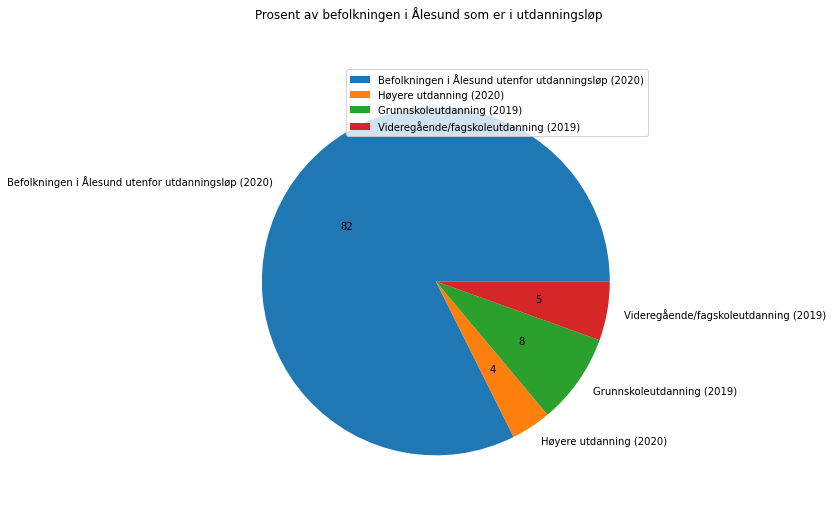

In [19]:
# plt.pie(df([1,2,3]))
#df6.antall.plot(kind='pie')
pai = 'Befolkningen i ' +kommuneNavn.capitalize() + ' utenfor utdanningsløp (2020)'
pai1 = 'Prosent av befolkningen i ' +kommuneNavn.capitalize() +' som er i utdanningsløp'
df4.plot.pie(title=pai1,labels=[pai, 'Høyere utdanning (2020)', 'Grunnskoleutdanning (2019)', 'Videregående/fagskoleutdanning (2019)'],autopct='%.0f',subplots=True,figsize=(8, 8))